# Topic Modelling with Latent Dirichlet Allocation (LDA)

In this notebook we conduct a preprocessing for LDA and LDA analysis to  extract topics from restaurants reviews

In [1]:
%load_ext autoreload

%autoreload 2

import time
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import emoji
import Preprocessing_topicM as preproc
import nltk
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Data preparation

In [2]:
reviews_raw = pd.read_csv(r"../data_hyderabad/10k_reviews.csv")

In [3]:
reviews_data = reviews_raw[reviews_raw["Rating"].notna() & reviews_raw["Review"].notna()]
reviews_data.isna().sum()

Restaurant    0
Reviewer      0
Review        0
Rating        0
Metadata      0
Time          0
Pictures      0
dtype: int64

In [4]:
# split UPPERCASE WORDS
def splitting_words_process(word):
    # only upper case letters
    if word.isupper():
        return word

    # more than one upper case letter inside
    elif re.search(r'[A-Z][a-z]*[A-Z]', word):
        split_word = re.findall(r'[A-Z][a-z]*', word)
        return ' '.join(split_word)

    # <2 upper case letters
    else:
        return word

reviews_data['Review'] = reviews_data['Review'].apply(lambda x: ' '.join([splitting_words_process(word) for word in x.split()]))

In [5]:
# Function to replace 'gud', 'goo', 'gd' with the appropriate 'good'
def replace_gud_with_good(text):
    if isinstance(text, str):
        # Define the regex pattern to match 'gud', 'goo', 'gd' in various capitalizations
        pattern = re.compile(r'\b([Gg][Uu][Dd]|[Gg][Oo][Oo]|[Gg][Dd])\b')

        # Replacement function to check the case of the first letter
        def replacement(match):
            word = match.group()
            # Check if the first letter is uppercase, then return 'Good', else 'good'
            if word[0].isupper():
                return 'Good'
            else:
                return 'good'

        # Use re.sub to apply the replacement function
        return pattern.sub(replacement, text)

    return text

# Apply the function to the 'Review' column to replace the variants of 'good'
reviews_data['Review'] = reviews_data['Review'].apply(replace_gud_with_good)

In [6]:
# Function to replace 'kk', 'Oke', 'k', 'Ok' with 'ok'
def replace_to_ok(text):
    if isinstance(text, str):
        # Define the regex pattern to match the variants of 'ok'
        pattern = re.compile(r'\b(k|kk|Ok|Oke)\b', re.IGNORECASE)

        # Replacement function to return 'ok' for all matched words
        def replacement(match):
            return 'ok'

        # Use re.sub to apply the replacement function
        return pattern.sub(replacement, text)

    return text

# Apply the function to the 'Review' column to replace the variants of 'ok'
reviews_data['Review'] = reviews_data['Review'].apply(replace_to_ok)

In [7]:
# add space after ! | " | # | $ | % | & | ( | ) | * | + | , | . | : | ; followed immediately by a word
def add_space_after_punctuation(df):

    df['Review'] = df['Review'].apply(lambda text: re.sub(r'([\u0021-\u0026\u0028-\u002C\u002E\u003A-\u003F]+(?=\w))', r'\1 ', text) if isinstance(text, str) else text)
    return df

# Example usage:
reviews_data = add_space_after_punctuation(reviews_data)

In [8]:
# remove gibberish words like "ggggggggggd", "eshjdgue"
def remove_gibberish(text):
    cleaned_text = re.sub(r'\b\w{15,}\b', '', text)  # removes 15+ words
    cleaned_text = re.sub(r'\b\w*(\w)\1{2,}\w*\b', '', cleaned_text)  # removes words that contain 3+ repeating letters

    return cleaned_text

reviews_data['Review'] = reviews_data['Review'].apply(remove_gibberish)

In [9]:
def remove_space_before_punctuation(text):
    if isinstance(text, str):
        # Define the regex pattern to match spaces before punctuation
        pattern = re.compile(r'\s+([?.!,;:])')

        # Use re.sub to remove spaces before punctuation
        return pattern.sub(r'\1', text)

    return text

# Apply the function to the 'Review' column to remove spaces before punctuation
reviews_data['Review'] = reviews_data['Review'].apply(remove_space_before_punctuation)

Apply following steps from general preprocessing:

- stopwords removal
- diacritics convertion
- punctuation removal
- emoji removal
- hashtags removal
- URLs removal
- remove newlines
- remove numbers
- lemmatize

In [12]:
reviews_data["Review_preproc"] = reviews_data['Review'].apply(lambda x: preproc.main_pipeline(
    x,
    print_output=False,
    no_stopwords=True,
    custom_stopwords=[],
    convert_diacritics=True,
    no_punctuation=True,
    remove_contractions=True,
    lowercase=True,
    lemmatized=True,
    stemmed=False,
    tokenized_output=False
))

In [13]:
def remove_space_before_punctuation(text):
    if isinstance(text, str):
        # Define the regex pattern to match spaces before punctuation
        pattern = re.compile(r'\s+([?.!,;:])')

        # Use re.sub to remove spaces before punctuation
        return pattern.sub(r'\1', text)

    return text

# Apply the function to the 'Review' column to remove spaces before punctuation
reviews_data["Review_preproc"] = reviews_data["Review_preproc"].apply(remove_space_before_punctuation)

In [14]:
# Remove reviews with less than 2 words
reviews_data = reviews_data[reviews_data["Review_preproc"].apply(lambda x: len(x.split()) > 1)]

In [15]:
len(reviews_data)

9273

In [16]:
reviews_preproc = reviews_data

### Latent Dirichlet Allocation

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from sklearn.model_selection import train_test_split

In [18]:
bow = CountVectorizer(ngram_range=(1,1), stop_words= "english", token_pattern=r"(?u)\b\w+\b")
bow_matrx = bow.fit_transform(reviews_preproc["Review_preproc"] )

In [19]:
tokenized_reviews = [nltk.word_tokenize(review) for review in reviews_data["Review_preproc"] ]
reviews_dict = corpora.Dictionary(tokenized_reviews)
reviews_corpus = [reviews_dict.doc2bow(doc) for doc in tokenized_reviews]

In [28]:
#Function to verify coherence score for LDA model with different number of topics

def lda_coherence(n_topics):
    coherences = []
    for n in n_topics:
        lda_model = LdaModel(corpus=reviews_corpus, id2word=reviews_dict, num_topics=n, random_state=42)
        coherence_model = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=reviews_dict, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherences.append(coherence_score)
    return coherences

Calculate Coherence scores for LDA model with different number of topics.

Model with 12 reviews yields the best result

In [29]:
lda_coherence([10,12,14,16,18,20])

[0.3798706003119968,
 0.37971451321252675,
 0.38440446409286055,
 0.35755772928657903,
 0.36377373191175877,
 0.34887295907734217]

Cross validate log_perplexity score depending on number of topics.

Output: it favorizes models with as little topics as possible, which is bad for interpretability, thus min 10 topics is considered

In [221]:
import numpy as np
from sklearn.model_selection import KFold
from gensim.corpora import Dictionary

# function to verify log perplexity on LDA model with different number of topics with 10 fold cross val

def cross_validate_lda(texts, 
                      n_topics,
                      n_splits= 5,
                      random_state= 42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    perplexities = []
    
    
    for train_idx, test_idx in kf.split(texts):
        # Prepare train/test splits
        train_texts = [texts[i] for i in train_idx]
        test_texts = [texts[i] for i in test_idx]
        
        # Create dictionary and bow corpus
        dictionary = Dictionary(train_texts)
        train_corpus = [dictionary.doc2bow(text) for text in train_texts]
        test_corpus = [dictionary.doc2bow(text) for text in test_texts]
        
        # Train model
        lda = LdaModel(
            corpus=train_corpus,
            id2word=dictionary,
            num_topics=n_topics,
            random_state=random_state
        )
        
        # Calculate perplexity
        perplexity = lda.log_perplexity(test_corpus)
        perplexities.append(perplexity)
        
    
    return np.mean(perplexities), np.std(perplexities)

# Usage example
def evaluate_topic_range(texts, 
                        min_topics = 5,
                        max_topics =20,
                        step = 1):
    results = []
    for n_topics in range(min_topics, max_topics + 1, step):
        mean_perp, std_perp = cross_validate_lda(texts, n_topics)
        results.append((n_topics, mean_perp, std_perp))
        print(f"Topics: {n_topics}, Perplexity: {mean_perp:.2f} ± {std_perp:.2f}")
    return results

evaluate_topic_range(tokenized_reviews, min_topics=10, max_topics=20, step=2)

Topics: 10, Perplexity: -8.81 ± 0.06
Topics: 12, Perplexity: -9.13 ± 0.08
Topics: 14, Perplexity: -9.36 ± 0.08
Topics: 16, Perplexity: -9.57 ± 0.07
Topics: 18, Perplexity: -9.76 ± 0.07
Topics: 20, Perplexity: -9.95 ± 0.07


[(10, -8.80972655931933, 0.06370965729925084),
 (12, -9.125753814660346, 0.0821577947430812),
 (14, -9.357210309673253, 0.07565817096008215),
 (16, -9.56928418253499, 0.06637634882240469),
 (18, -9.760385992400625, 0.0733758091723622),
 (20, -9.95438875219627, 0.06513520769237821)]

In [215]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from tqdm import tqdm

def tune_lda_parameters(
    texts,
    param_grid = {
        'num_topics': [8,10,12,14],
        'alpha': ['symmetric', 'auto'],
        'beta': [0.01, 0.1, 0.5],
        'passes': [5, 10],
        'chunksize': [100, 500]
    },
    random_state = 42,
    early_stopping_rounds = 5,
    min_improvement = 0.01
):
    
    # Prepare data
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    # Initialize tracking
    results = []
    best_score = -np.inf
    best_model = None
    best_params = None
    no_improvement = 0
    
    # Generate parameter combinations
    param_combinations = list(product(
        param_grid['num_topics'],
        param_grid['alpha'],
        param_grid['beta'],
        param_grid['passes'],
        param_grid['chunksize']
    ))
    
    for params in tqdm(param_combinations):
        n_topics, alpha, beta, passes, chunksize = params
        
        # Train model
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=n_topics,
            alpha=alpha,
            eta=beta,
            passes=passes,
            chunksize=chunksize,
            random_state=random_state
        )
        
        # Calculate coherence
        coherence = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        ).get_coherence()
        
        # Track results
        results.append({
            'num_topics': n_topics,
            'alpha': alpha,
            'beta': beta,
            'passes': passes,
            'chunksize': chunksize,
            'coherence': coherence
        })
        
        # Update best model
        if coherence > best_score + min_improvement:
            best_score = coherence
            best_model = model
            best_params = dict(zip(
                ['num_topics', 'alpha', 'beta', 'passes', 'chunksize'],
                params
            ))
            no_improvement = 0
        else:
            no_improvement += 1
            
        # Early stopping
        if no_improvement >= early_stopping_rounds:
            break
            
    return results,best_model, best_params, pd.DataFrame(results)

In [133]:
tune_lda_parameters(tokenized_reviews)

 10%|█         | 10/96 [06:21<54:39, 38.13s/it]


([{'num_topics': 8,
   'alpha': 'symmetric',
   'beta': 0.01,
   'passes': 5,
   'chunksize': 100,
   'coherence': 0.393259206875846},
  {'num_topics': 8,
   'alpha': 'symmetric',
   'beta': 0.01,
   'passes': 5,
   'chunksize': 500,
   'coherence': 0.45320035444053375},
  {'num_topics': 8,
   'alpha': 'symmetric',
   'beta': 0.01,
   'passes': 10,
   'chunksize': 100,
   'coherence': 0.4052440430856622},
  {'num_topics': 8,
   'alpha': 'symmetric',
   'beta': 0.01,
   'passes': 10,
   'chunksize': 500,
   'coherence': 0.43095740129693444},
  {'num_topics': 8,
   'alpha': 'symmetric',
   'beta': 0.1,
   'passes': 5,
   'chunksize': 100,
   'coherence': 0.3868330444718733},
  {'num_topics': 8,
   'alpha': 'symmetric',
   'beta': 0.1,
   'passes': 5,
   'chunksize': 500,
   'coherence': 0.47977312076913975},
  {'num_topics': 8,
   'alpha': 'symmetric',
   'beta': 0.1,
   'passes': 10,
   'chunksize': 100,
   'coherence': 0.37764943760070413},
  {'num_topics': 8,
   'alpha': 'symmetric',


In [34]:
lda_gensim = LdaModel(corpus = reviews_corpus, id2word = reviews_dict, num_topics=14, iterations =50, random_state=42)

In [37]:
lda_gensim.show_topics(14)

[(0,
  '0.020*"food" + 0.017*"time" + 0.015*"delivery" + 0.014*"get" + 0.014*"order" + 0.012*"place" + 0.012*"go" + 0.011*"bad" + 0.009*"give" + 0.009*"love"'),
 (1,
  '0.053*"good" + 0.029*"food" + 0.026*"place" + 0.026*"nice" + 0.021*"service" + 0.020*"ambience" + 0.013*"really" + 0.011*"sport" + 0.010*"great" + 0.009*"american"'),
 (2,
  '0.034*"place" + 0.021*"good" + 0.014*"food" + 0.011*"one" + 0.009*"go" + 0.009*"drink" + 0.008*"service" + 0.007*"order" + 0.007*"even" + 0.007*"-"'),
 (3,
  '0.071*"good" + 0.025*"taste" + 0.020*"delivery" + 0.019*"food" + 0.017*"bread" + 0.011*"cake" + 0.010*"also" + 0.010*"paratha" + 0.010*"service" + 0.010*"parathas"'),
 (4,
  '0.021*"take" + 0.018*"service" + 0.017*"even" + 0.016*"ask" + 0.014*"come" + 0.014*"order" + 0.013*"food" + 0.013*"bad" + 0.013*"u" + 0.012*"say"'),
 (5,
  '0.053*"order" + 0.049*"chicken" + 0.024*"momos" + 0.021*"food" + 0.020*"bad" + 0.018*"deliver" + 0.014*"rice" + 0.013*"zomato" + 0.013*"quality" + 0.013*"biryani"'),

In [39]:
# Save the top 3 words for each topic
top_words_per_topic = []
for topic_id, topic in lda_gensim.show_topics(formatted=False, num_words=3, num_topics=14):
    top_words = [word for word, _ in topic]
    top_words_per_topic.append((topic_id, top_words))

top_words_per_topic

[(0, ['food', 'time', 'delivery']),
 (1, ['good', 'food', 'place']),
 (2, ['place', 'good', 'food']),
 (3, ['good', 'taste', 'delivery']),
 (4, ['take', 'service', 'even']),
 (5, ['order', 'chicken', 'momos']),
 (6, ['good', 'taste', 'food']),
 (7, ['order', 'burger', 'good']),
 (8, ['pork', 'food', 'quantity']),
 (9, ['chocolate', 'place', 'try']),
 (10, ['chicken', 'good', 'taste']),
 (11, ['order', 'wait', 'restaurant']),
 (12, ['place', 'food', 'good']),
 (13, ['food', 'service', 'place'])]

In [23]:
def get_top_topics_for_reviews(reviews_corpus, lda_model, n=3):
    top_topics = []
    for doc in reviews_corpus:
        topics = lda_model.get_document_topics(doc, minimum_probability=0)
        sorted_topics = sorted(topics, key=lambda x: x[1], reverse=True)[:n]
        top_topics.append(sorted_topics)
    return top_topics

# get top 3 topics for each review
top_topics_per_review = get_top_topics_for_reviews(reviews_corpus, lda_gensim, n=3)

reviews_data['Top_Topics'] = [ [top_words_per_topic[topic][1] for topic, _ in topics] for topics in top_topics_per_review ]
reviews_data['Topics_Probabilities'] = [ [prob for _, prob in topics] for topics in top_topics_per_review ]

# Save it to new dataframe
reviews_with_topics_lda = reviews_data[["Review","Review_preproc","Top_Topics","Topics_Probabilities"]]


In [24]:
reviews_with_topics_lda

,Review,Review_preproc,Top_Topics,Topics_Probabilities
0,"The ambience was good, food was quite good. ha...",ambience good food quite good saturday lunch c...,"[[place, good, food], [place, food, good], [or...","[0.5707213, 0.3947764, 0.0034503203]"
1,Ambience is too good for a pleasant evening. S...,ambience good pleasant even service prompt foo...,"[[good, food, service], [place, good, food], [...","[0.9216793, 0.026098067, 0.0052223313]"
2,A must try.. great food great ambience. Thnx f...,must try great food great ambience thnx servic...,"[[place, food, good], [order, get, make], [pla...","[0.9535473, 0.004223217, 0.004223086]"
3,Soumen das and Arun was a great guy. Only beca...,soumen da arun great guy behavior sincerety go...,"[[good, food, service], [place, good, food], [...","[0.93799937, 0.0056366893, 0.005636474]"
4,Food is good. we ordered Kodi drumsticks and b...,food good order kodi drumstick basket mutton b...,"[[good, food, service], [place, food, good], [...","[0.87477815, 0.07885056, 0.00463718]"
...,...,...,...,...
9995,Madhumathi Mahajan Well to start with nice cou...,madhumathi mahajan well start nice courteous s...,"[[chicken, good, place], [place, good, food], ...","[0.5044187, 0.19925715, 0.13229725]"
9996,This place has never disappointed us.. The foo...,place never disappoint u food courteous staff ...,"[[food, good, service], [chicken, good, place]...","[0.40955445, 0.31798548, 0.15082447]"
9997,"Bad rating is mainly because of "" Chicken Bone...",bad rat mainly chicken bone find veg food acce...,"[[chicken, good, place], [food, good, veg], [o...","[0.72696424, 0.09289695, 0.07060245]"
9998,I personally love and prefer Chinese Food. Had...,personally love prefer chinese food couple tim...,"[[place, food, good], [chicken, good, place], ...","[0.4696384, 0.32020637, 0.10929151]"


## Final model evaluation

In [40]:
# Model with 14 topics has Coherence = 0.38

cm = CoherenceModel(model=lda_gensim, texts=tokenized_reviews, dictionary=reviews_dict, coherence='c_v')
cm.get_coherence()  

0.38440446409286055

In [26]:
# Coherence per topic

cm_topic = cm.get_coherence_per_topic()
topics = [topic[0] for topic in lda_gensim.show_topics(num_topics=20)]
topics_coherence = pd.DataFrame({'Topic': topics, 'Coherence': cm_topic})

topics_coherence

,Topic,Coherence
0,0,0.386133
1,1,0.416876
2,2,0.294217
3,3,0.408944
4,4,0.354447
5,5,0.286139
6,6,0.319184
7,7,0.384250
8,8,0.323696
9,9,0.309494


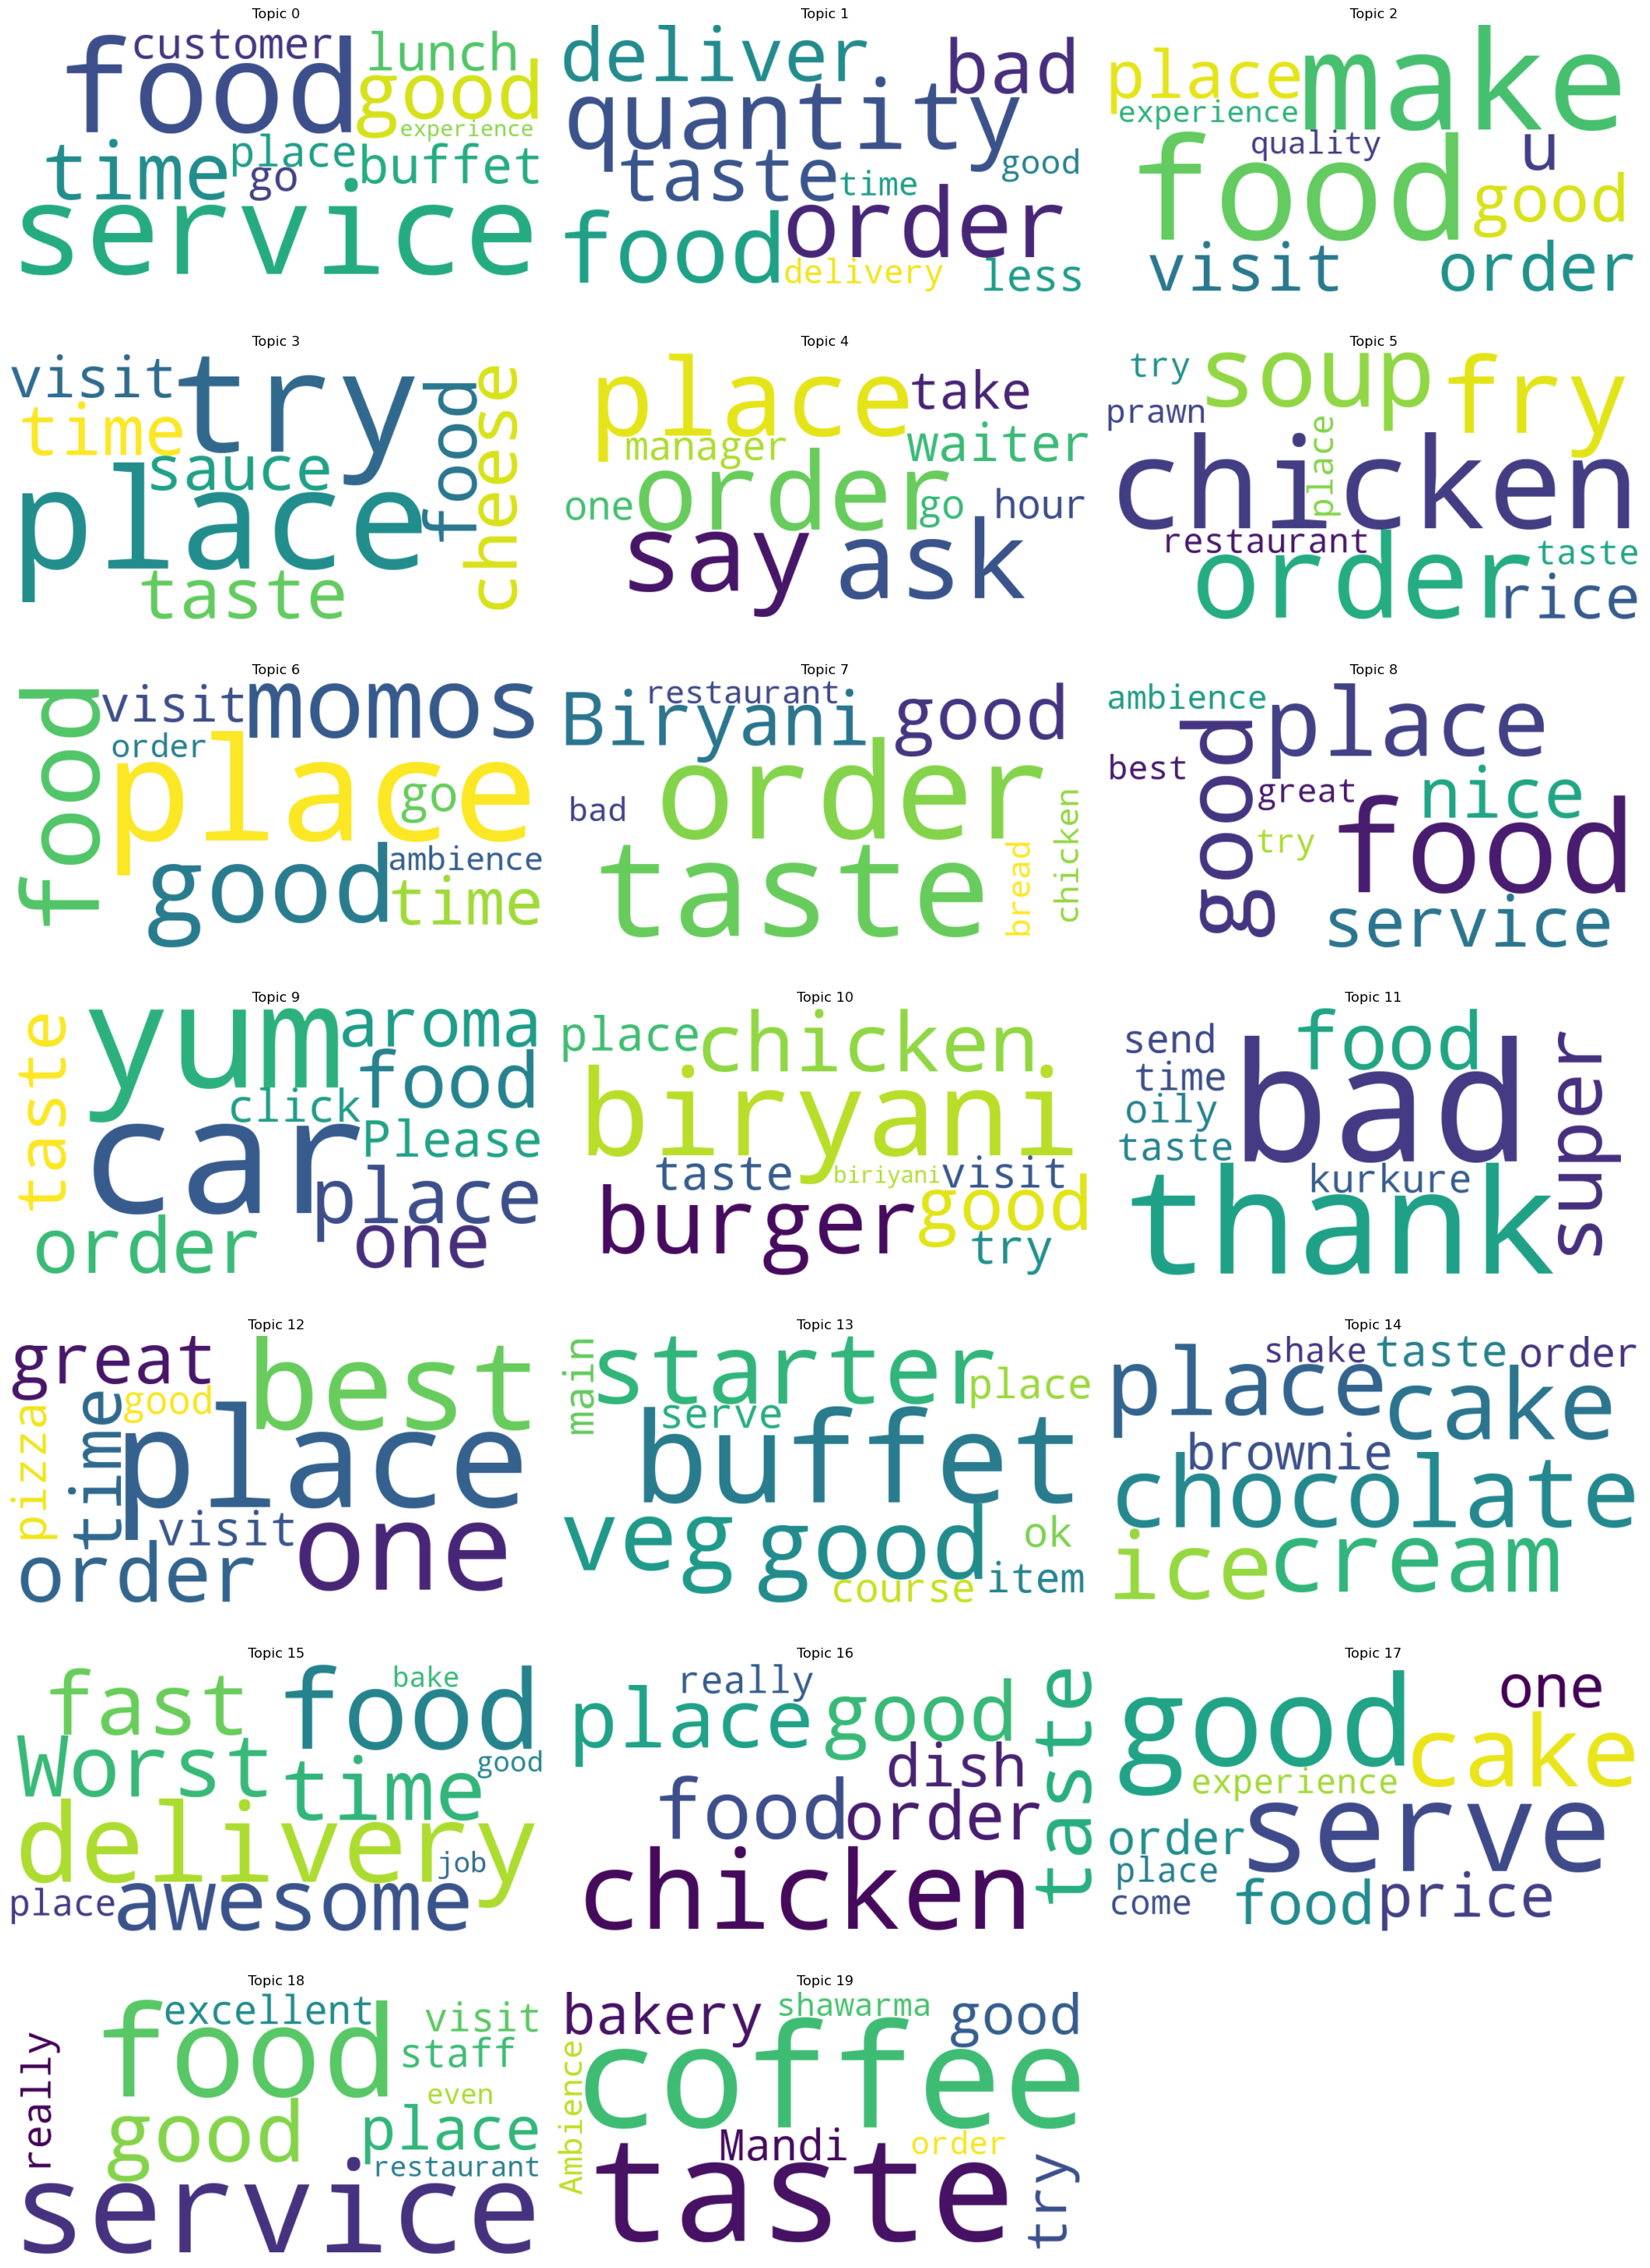

In [ ]:
#this code below was generatd by claude copilot

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_topic_wordcloud(lda_model, num_topics=20, num_words=10):
    # Create a figure with subplots
    n_cols = 3  # You can adjust number of columns
    n_rows = (num_topics + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(20, 4*n_rows))
    
    for topic_id in range(num_topics):
        # Create subplot for each topic
        ax = fig.add_subplot(n_rows, n_cols, topic_id + 1)
        
        # Get words for current topic
        topic_words = lda_model.show_topic(topic_id, topn=num_words)
        words = ' '.join([word for word, _ in topic_words])
        
        # Generate word cloud
        wordcloud = WordCloud(
            width=800, 
            height=400,
            background_color='white',
            max_words=num_words
        ).generate(words)
        
        # Display word cloud
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'Topic {topic_id}')
    
    plt.tight_layout()
    plt.show()

# Create word clouds for each topic
create_topic_wordcloud(lda_gensim, num_topics=20, num_words=10)
